In [1]:
push!(LOAD_PATH, joinpath(@__DIR__, "../../lib"));

In [2]:
using BenchmarkTools
using NLopt
using Statistics
using PyPlot

In [3]:
using MSSim
const Opts = MSSim.Optimizers
const SS = MSSim.SegSeq
const SL = MSSim.SymLinear
const Seq = MSSim.Sequence

MSSim.Sequence

In [4]:
const radial_modes = [
    2.35809,
    2.40675,
    2.44923,
    2.48561,
    2.5164,
    2.54068,
    2.55792
];
const lamb_dicke_parameters = [
    0.12535185674701685,
    0.12411265750465082,
    0.12305413516480627,
    0.12216335005557813,
    0.12143343371677694,
    0.12086534864431214,
    0.12047167276221905
];
const participation_factors = [
    0.02222009251306859 -0.1722648656984975 0.48939776715759997 -0.678705987944334 0.4893977671575958 -0.17226486569849606 0.022220092513065576
    -0.08507556148734259 0.4120558633416861 -0.5683063560469468 0.0 0.5683063560469427 -0.4120558633416741 0.08507556148733478
    -0.21303936535968387 0.5714074376873661 -0.11990319870608773 -0.4769297472432097 -0.1199031987060997 0.5714074376873872 -0.2130393653596884
    0.39521513624944005 -0.44499802171470876 -0.38181377234109953 0.0 0.38181377234109876 0.4449980217146981 -0.39521513624943017
    0.5579098076201139 -0.031003440845807535 -0.3213345695440472 -0.41114359446049004 -0.3213345695440565 -0.031003440845817597 0.5579098076201152
    -0.5801440725517667 -0.3635749250921281 -0.1767657459105281 0.0 0.176765745910517 0.3635749250921191 0.5801440725517734
    0.37796447300922137 0.37796447300923375 0.37796447300922364 0.3779644730092235 0.37796447300922775 0.37796447300923464 0.37796447300922603
];

In [5]:
const modes = Seq.Modes()
const ion1 = 2
const ion2 = 6
for i in 1:7
    push!(modes, 2π * radial_modes[i], participation_factors[i, ion1] * participation_factors[i, ion2] * lamb_dicke_parameters[i]^2)
end

In [6]:
function blackman_start_end(x)
    if -0.5 <= x <= 0.5
        return 1.0
    elseif x < 0
        x = (x + 0.5) * 2
    else
        x = (x - 0.5) * 2
    end
    return 0.42 + 0.5 * cospi(x) + 0.08 * cospi(2 * x)
end

blackman_start_end (generic function with 1 method)

In [7]:
const nseg = 120
const buf_opt = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_allδ), Val(SS.mask_allδ));
const buf_plot = SL.ComputeBuffer{nseg,Float64}(Val(SS.mask_full), Val(SS.mask_full));

In [8]:
function _objfunc(vals)
    dis = vals[1]
    disδ = vals[2]
    area = vals[3]
    areaδ = vals[4]
    τ = vals[5]

    return 5 * dis + disδ / 100 + (abs(area) - π / 2)^2 * 100 + (areaδ / 1e4)^2
end
const objfunc = Opts.autodiff(_objfunc);

In [9]:
const nlmodel = Seq.Objective(SL.pmask_full,
                              ((:dis2, 0), (:disδ2, 0), (:area, 0),
                               (:areaδ, 0), (:τ, 0)),
                              objfunc, modes, buf_opt,
                              freq=Seq.FreqSpec(true, sym=false),
                              amp=Seq.AmpSpec(cb=blackman_start_end, mid_order=-1));

In [10]:
const nargs = Seq.nparams(nlmodel)
const tracker = Opts.NLVarTracker(nargs)
Opts.set_bound!(tracker, nlmodel.param.τ, 0.1, 2)
Opts.set_bound!(tracker, nlmodel.param.Ωbase, 0.5, 0.70)
for ω in nlmodel.param.ωs
    Opts.set_bound!(tracker, ω, 2π * 2.39, 2π * 2.52)
end

In [11]:
# const opt = NLopt.Opt(:LD_SLSQP, nargs)
const opt = NLopt.Opt(:LD_LBFGS, nargs)
# NLopt.xtol_rel!(opt, 1e-5)
# NLopt.ftol_rel!(opt, 1e-5)
NLopt.min_objective!(opt, nlmodel)
NLopt.lower_bounds!(opt, Opts.lower_bounds(tracker))
NLopt.upper_bounds!(opt, Opts.upper_bounds(tracker))
NLopt.maxtime!(opt, 10)

In [12]:
best_obj = 100.0
best_params = nothing
@time for i in 1:50
    global best_obj, best_params
    obj, params, ret = @time NLopt.optimize(opt, Opts.init_vars!(tracker))
    if getfield(NLopt, ret) < 0
        continue
    end
    if obj < best_obj
        best_obj = obj
        area = nlmodel(Val((:area, 0)), params)
        best_status = (
            obj = obj,
            dis = nlmodel(Val((:dis2, 0)), params),
            disδ = nlmodel(Val((:disδ2, 0)), params),
            area = area,
            areaε = abs(area) - π / 2,
            areaδ = nlmodel(Val((:areaδ, 0)), params),
            total_t = nlmodel(Val((:τ, 0)), params),
            Ωmax = params[nlmodel.param.Ωbase],
        )
        println(best_status)
        best_params = params
    end
end

  3.180670 seconds (10.88 M allocations: 536.696 MiB, 6.43% gc time, 99.70% compilation time)
 10.000311 seconds (1.56 M allocations: 80.454 MiB, 0.20% gc time)
(obj = 1.140072838751166e-6, dis = 1.1500183592213688e-11, disδ = 2.0218133151494603e-10, area = 1.5707963194106402, areaε = -7.384256317521931e-9, areaδ = -10.677140584291122, total_t = 199.85594208804636, Ωmax = 0.5414236788663512)
  0.009809 seconds (1.49 k allocations: 80.109 KiB)
  0.009300 seconds (1.41 k allocations: 75.891 KiB)
  0.008258 seconds (1.25 k allocations: 67.875 KiB)
 10.000138 seconds (1.62 M allocations: 83.466 MiB, 0.13% gc time)
 10.000242 seconds (1.58 M allocations: 81.458 MiB, 0.04% gc time)
  0.521739 seconds (63.97 k allocations: 3.296 MiB, 0.20% gc time)
  0.011609 seconds (1.76 k allocations: 94.875 KiB)
  4.463359 seconds (592.12 k allocations: 30.495 MiB, 0.04% gc time)
  0.008643 seconds (1.31 k allocations: 70.828 KiB)
 10.000030 seconds (1.59 M allocations: 81.769 MiB, 0.05% gc time)
  0.4352

In [13]:
opt_raw_params = Seq.RawParams(nlmodel, best_params)
println(opt_raw_params)

MSSim.Sequence.RawParams([1.3197118997798039, -7.433318994271841e-18, 0.0004021572069080606, 0.0, 15.545678888633661, 1.3197118997798039, 0.0005307316515387689, 0.0012253017021762174, 20.51581741948552, 15.63263578049471, 1.3197118997798039, 0.0021477768887211723, 0.0021037146020494737, 41.14639288392793, 15.241561664058786, 1.3197118997798039, 0.004924074082786397, 0.0030702264808438527, 61.26086318321398, 15.376596018646246, 1.3197118997798039, 0.0089758885045751, 0.004151844993476974, 81.55353992712818, 15.088205249620586, 1.3197118997798039, 0.014455127748507865, 0.005367815806328792, 101.46562394137258, 15.468006264954123, 1.3197118997798039, 0.021539098143946094, 0.00672805268868347, 121.87893587510109, 15.375928873106018, 1.3197118997798039, 0.030418189339547173, 0.008232013361959232, 142.17073217910698, 15.405166303019449, 1.3197118997798039, 0.04128207533247112, 0.009868077806845532, 162.5011134672886, 15.772994150831876, 1.3197118997798039, 0.05430509504211816, 0.011613463270

In [14]:
kern = SL.Kernel(buf_plot, Val(SL.pmask_full));

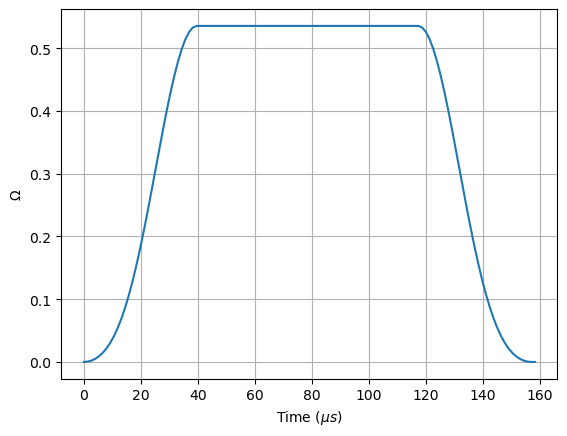

In [15]:
plot(Seq.get_Ωs(opt_raw_params)...)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\Omega$")
grid()

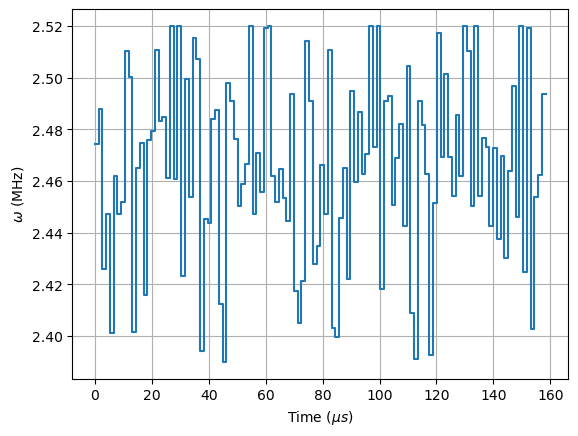

In [16]:
ts, ωs = Seq.get_ωs(opt_raw_params)
plot(ts, ωs ./ 2π)
xlabel(raw"Time ($\mu s$)")
ylabel(raw"$\omega$ (MHz)")
grid()

In [17]:
Seq.total_dis(kern, opt_raw_params, modes)

2.997680868170161e-15

In [18]:
Seq.total_cumdis(kern, opt_raw_params, modes)

8.03303035285461e-11

In [19]:
Seq.total_disδ(kern, opt_raw_params, modes)

1.058379827489824e-13

In [20]:
Seq.total_area(kern, opt_raw_params, modes)

1.5707963217450398

In [21]:
Seq.total_areaδ(kern, opt_raw_params, modes)

-8.888323103893647

In [22]:
plot_δs = range(-1, 1, 10001); # kHz

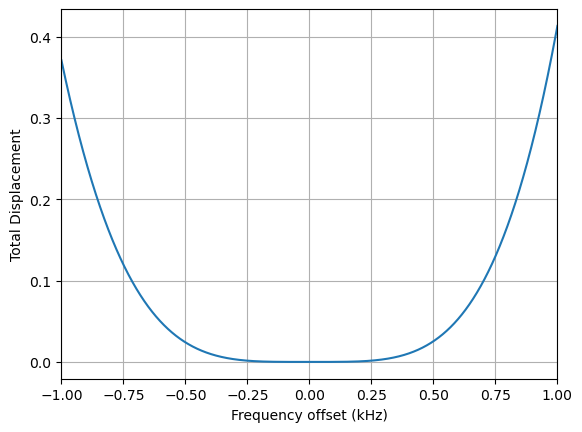

In [23]:
plot(plot_δs, [Seq.total_dis(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) for δ in plot_δs])
xlim([-1, 1])
# ylim([0, 100])
xlabel("Frequency offset (kHz)")
ylabel("Total Displacement")
grid()

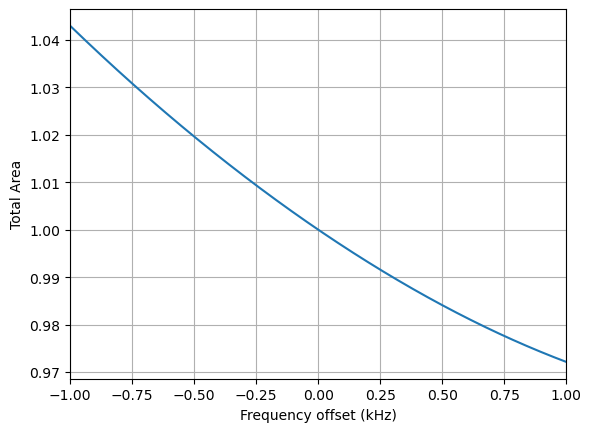

In [24]:
area0 = Seq.total_area(kern, opt_raw_params, modes)
plot(plot_δs, [Seq.total_area(kern, Seq.adjust(opt_raw_params, δ=2π * δ / 1000), modes) / area0 for δ in plot_δs])
xlim([-1, 1])
xlabel("Frequency offset (kHz)")
ylabel("Total Area")
grid()

In [25]:
_, xs1, ys1 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[1][1])
_, xs2, ys2 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[2][1])
_, xs3, ys3 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[3][1])
_, xs4, ys4 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[4][1])
_, xs5, ys5 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[5][1])
_, xs6, ys6 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[6][1])
_, xs7, ys7 = Seq.get_trajectory(opt_raw_params, 10001; ωm=modes[7][1]);

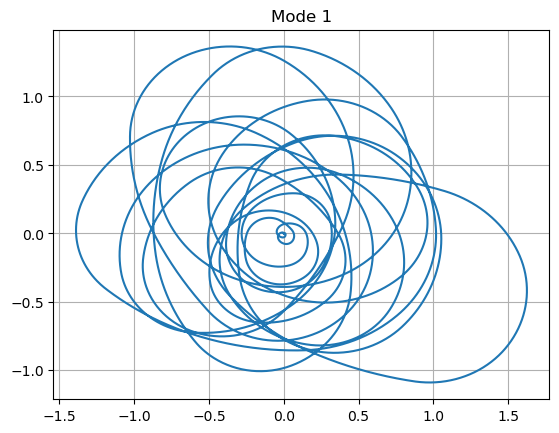

In [26]:
plot(xs1, ys1)
title("Mode 1")
grid()

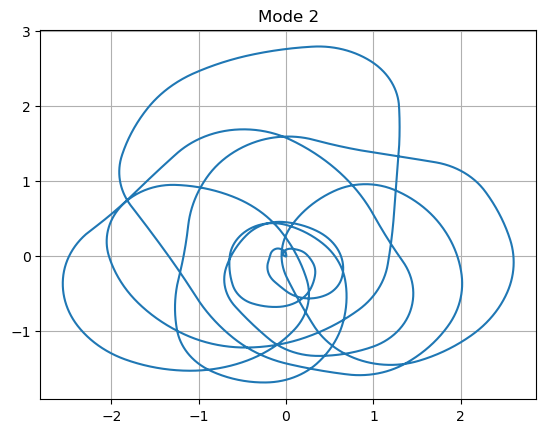

In [27]:
plot(xs2, ys2)
title("Mode 2")
grid()

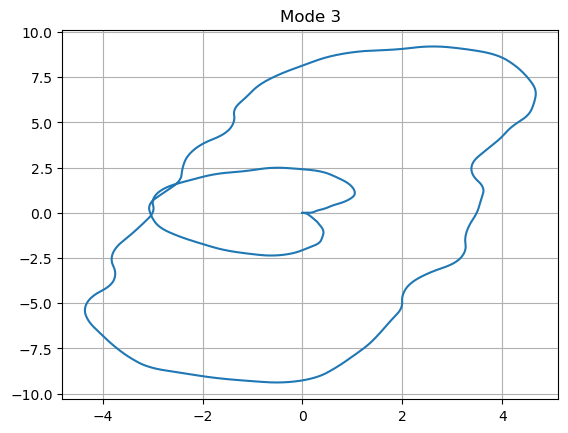

In [28]:
plot(xs3, ys3)
title("Mode 3")
grid()

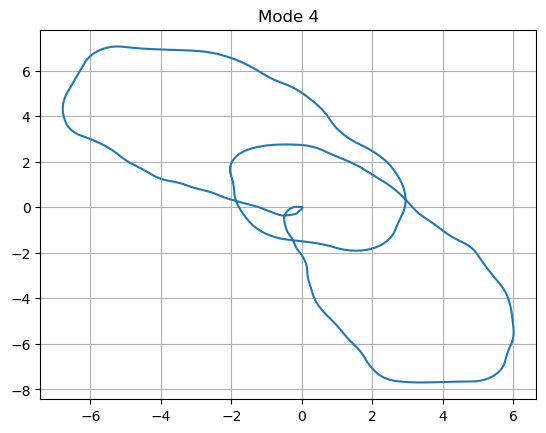

In [29]:
plot(xs4, ys4)
title("Mode 4")
grid()

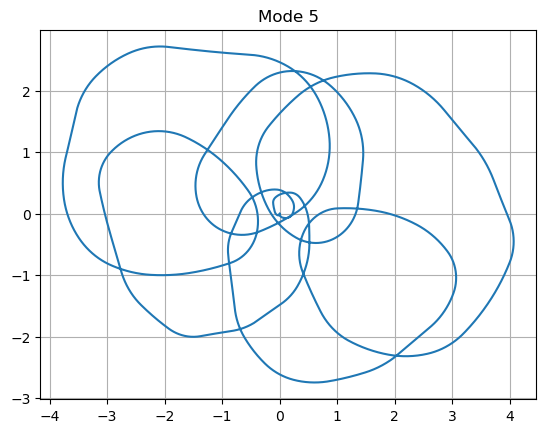

In [30]:
plot(xs5, ys5)
title("Mode 5")
grid()

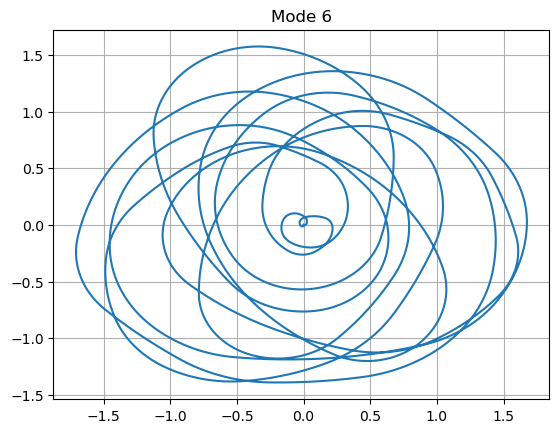

In [31]:
plot(xs6, ys6)
title("Mode 6")
grid()

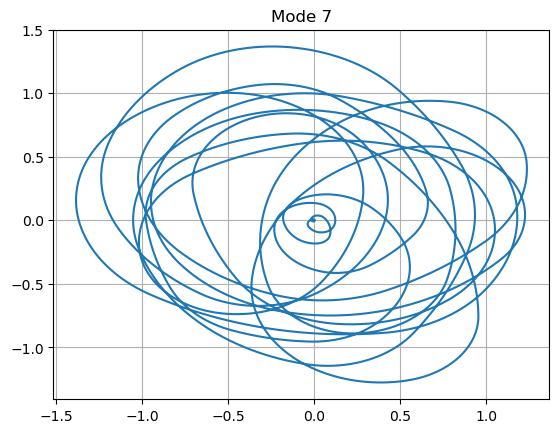

In [32]:
plot(xs7, ys7)
title("Mode 7")
grid()